<h2
    style="font-size:20px; font-family:'Helvetica Neue'" align="right"> Viktor Trokhymenko 
</h2>
<h3 
    style="font-size:16px; font-family:'Helvetica Neue'" align="right"> @vtrokhymenko
</h3>

In [67]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.random.seed(42)
import re
from pprint import pprint
import ast

import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
import scipy.sparse as ss
from sklearn.feature_extraction.text import CountVectorizer

# https://github.com/gregversteeg/corex_topic
from corextopic import corextopic as ct
from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

import _pickle as cPickle
import pickle

---

In [86]:
%%time

df=pd.read_csv('data/news_lenta_pymorphy.csv.zip')
print(df.shape)

(699777, 3)
CPU times: user 21.6 s, sys: 1.29 s, total: 22.9 s
Wall time: 23.1 s


In [87]:
%%time

# приведем поле `text_pymorphy` к `literal_eval`
df['text_pymorphy'] = df.text_pymorphy.apply(lambda x: ast.literal_eval(x))

# подсчитаем к-ство токенов для каждой записи
df['len'] = df.text_pymorphy.apply(lambda x: len(x))

# оставим где к-ство токенов >3 для каждого дока (но тут нужно еще подумать)
df = df[df.len > 3]

CPU times: user 3min 6s, sys: 1min 8s, total: 4min 14s
Wall time: 4min 34s


In [88]:
%%time

# джойним лист, для дальнейшей работы
df['text_join'] = df.text_pymorphy.apply(lambda x: ' '.join(x))

CPU times: user 12.6 s, sys: 42.4 s, total: 55 s
Wall time: 1min 2s


In [89]:
# объединим год и месяц, добавляя статическую дату
# это делается для последующей визуализации

def prepare_date2vis(year,month,day=11):
    if len(str(month))==2:
        return str(int(year))+'-'+str(int(month))+'-'+str(day)
    else:
        return str(int(year))+'-0'+str(int(month))+'-'+str(day)

print(prepare_date2vis(2018,8))
print(prepare_date2vis(2018,12))

2018-08-11
2018-12-11


In [90]:
%%time
df['date'] = df.apply(lambda x: prepare_date2vis(x.year, x.month), axis=1)

CPU times: user 18 s, sys: 314 ms, total: 18.3 s
Wall time: 18.4 s


In [91]:
# как мы знаем, то в этом датасете есть 1914 год
# мы его дропаем
df = df[df.year != 1914]

# добавляем `docID` чтобы потом смерждить по этому полю
df['docID'] = [i for i in range(df.shape[0])]

In [92]:
# смотрим что получилось
print(df.shape)
df.head(3)

(699484, 7)


,year,month,text_pymorphy,len,text_join,date,docID
0,2018,7,"[украинский, боксёр, александр, усик, рассказа...",111,украинский боксёр александр усик рассказать ра...,2018-07-11,0
1,2018,7,"[израиль, эвакуировать, сирия, активист, белых...",89,израиль эвакуировать сирия активист белых каск...,2018-07-11,1
2,2018,7,"[лондонский, челси, отказаться, продать, мадри...",89,лондонский челси отказаться продать мадридский...,2018-07-11,2


---

### CountVectorizer

In [94]:
%%time

# делаем мешок слов
vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(df.text_join)

# делаем спарс-матрцу
doc_word = ss.csr_matrix(doc_word)

print(doc_word.shape)  # n_docs x m_words

(699484, 556556)
CPU times: user 1min 19s, sys: 6.95 s, total: 1min 26s
Wall time: 1min 29s


699489 документов с 556574 словами

In [96]:
%%time

# получаем слова
words = list(np.asarray(vectorizer.get_feature_names()))

# удаляем целые числа
not_digit_inds = [ind for ind, word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:, not_digit_inds]
words = [word for ind, word in enumerate(words) if not word.isdigit()]

print(doc_word.shape)  # n_docs x m_words

(699484, 556556)
CPU times: user 8.08 s, sys: 917 ms, total: 9 s
Wall time: 9.02 s


In [98]:
print(words[:10])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaab', 'aaab', 'aaae', 'aaariess', 'aaas']


## CorEx Topic Model

The main parameters of the CorEx topic model are:
* **n_hidden:** number of topics ("hidden" as in "hidden latent topics")
* **words:** words that label the columns of the doc-word matrix (optional)
* **docs:** document labels that label the rows of the doc-word matrix (optional)
* **max_iter:** number of iterations to run through the update equations (optional, defaults to 200)
* **verbose:** if verbose=1, then CorEx will print the topic TCs with each iteration
* **seed:** random number seed to use for model initialization (optional)


In [99]:
# задаем к-ство топиков (для примера взял 50)
NUM_TOPICS = 50

In [100]:
%%time
topic_model = ct.Corex(n_hidden=NUM_TOPICS,
                       words=words,
                       max_iter=200,
                       verbose=0,
                       seed=1)
topic_model.fit(doc_word, words=words)

CPU times: user 2h 17min 18s, sys: 45min 14s, total: 3h 2min 33s
Wall time: 3h 2min 36s


### topics

In [101]:
# посмотрим что отнеслось к 1 топику
topic_model.get_topics(topic=1, n_words=10)

[('фильм', 0.11684665449587389),
 ('режиссёр', 0.07228490852002444),
 ('картина', 0.05844012083809584),
 ('актёр', 0.05545439735479931),
 ('роль', 0.04265956101727018),
 ('музыкант', 0.038816523935299795),
 ('премия', 0.035909778607846596),
 ('альбом', 0.034692191709201736),
 ('прокат', 0.029907512032998997),
 ('песня', 0.028262502735602636)]

In [102]:
# получим индексы столбцов
topic_model.get_topics(topic=1, n_words=10, print_words=False)

[(507776, 0.11684665449587389),
 (433667, 0.07228490852002444),
 (292235, 0.05844012083809584),
 (164791, 0.05545439735479931),
 (438991, 0.04265956101727018),
 (356860, 0.038816523935299795),
 (416238, 0.035909778607846596),
 (167031, 0.034692191709201736),
 (420587, 0.029907512032998997),
 (400555, 0.028262502735602636)]

In [103]:
# посмотрим все топики
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: матч,чемпионат,команда,сборный,клуб,турнир,чемпион,тренер,игра,сборная
1: фильм,режиссёр,картина,актёр,роль,музыкант,премия,альбом,прокат,песня
2: пользователь,сервис,интернет,разработчик,сеть,выпустить,google,смартфон,компьютер,apple
3: погибнуть,произойти,человек,ранение,происшествие,пострадать,район,результат,взрыв,пострадавший
4: учёный,исследователь,исследование,журнал,университет,земля,поверхность,nature,астроном,планета
5: самолёт,борт,полёт,экипаж,авиакомпания,рейс,корабль,воздушный,пассажир,аэропорт
6: процент,рост,вырасти,показатель,снижение,сравнение,уровень,экономика,снизиться,объесть
7: аль,израиль,ирак,израильский,сирия,палестинский,иракский,оон,сирийский,иран
8: уголовный,дело,возбудить,задержать,следствие,следственный,правоохранительный,орган,статья,прокуратура
9: суд,приговорить,адвокат,иск,судебный,лишение,приговор,виновный,признать,свобода
10: доллар,миллиард,рубль,миллион,сумма,финансовый,банка,деньга,банк,бюджет
11: the,сша,американский,press,штат,associated,бри

In [104]:
# получим доступ к топику что присвоилось для каждого слова
print(topic_model.clusters.shape) # m_words
print(topic_model.clusters)

(556556,)
[ 6  6  2 ... 14  2 39]


### document labels

In [105]:
# документы сортируются с логарифмической вероятностью, к примеру [e^0=1,e^(-0,5)=0,6]
topic_model.get_top_docs(topic=1, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(498937, 0.0),
 (54346, 0.0),
 (678748, 0.0),
 (508262, 0.0),
 (384262, 0.0),
 (54357, 0.0),
 (186469, 0.0),
 (421872, 0.0),
 (124270, 0.0),
 (384276, 0.0)]

CorEx is a discriminative model, whereas LDA is a generative model.

In [106]:
# получим оценочные вероятности тем для каждого документа
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(699484, 50)


In [107]:
topic_model.p_y_given_x

array([[9.99999000e-01, 1.00000000e-06, 1.00000000e-06, ...,
        2.57855363e-03, 1.45493827e-02, 4.10339739e-02],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.57635979e-03, 1.64034357e-02, 4.14124341e-02],
       [9.99999000e-01, 1.00000000e-06, 1.00000000e-06, ...,
        2.57568138e-03, 1.53463513e-02, 3.10632475e-01],
       ...,
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.57563047e-03, 1.69765277e-02, 9.90752369e-01],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.58361228e-03, 5.14110845e-02, 3.92602527e-02],
       [1.00000000e-06, 1.00000000e-06, 2.66915401e-06, ...,
        2.58547556e-03, 1.56773840e-02, 8.19884104e-02]])

In [108]:
# также можно и юзать softmax для двоичного определения (какие документы принадлежат для каждой темы)
print(topic_model.labels.shape) # n_docs x k_topics

(699484, 50)


In [109]:
topic_model.labels

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Total Correlation and Model Selection

* Overall TC

при построении topic modelling, CorEx максимизирует меру total correlation

In [110]:
topic_model.tc

43.62742526586606

**Model selection**: CorEx starts its algorithm with a random initialization, and so different runs can result in different topic models. One way of finding a better topic model is to restart the CorEx algorithm several times and take the run that has the highest TC value (i.e. the run that produces topics that are most informative about the documents).

* Topic TC

обобщенная корреляция - это сумма общей корреляции по каждой из тем.

Для unsupervised CorEx темы всегда сортируются от высокого к низкому согласно с их TC

In [111]:
topic_model.tcs.shape # k_topics

(50,)

In [112]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

43.62742526586606
43.62742526586606


_Selecting number of topics_:

один из способов - наблюдать за распределением TCs на каждой эпохе, чтобы видеть какой дополнительный топик вносит вклад в общий TC

добавляем топики пока дополнительный топики не будут делать существенное вложение с общий TC

это похоже на выбор обрезания собственного значения при topic modeling через lsa

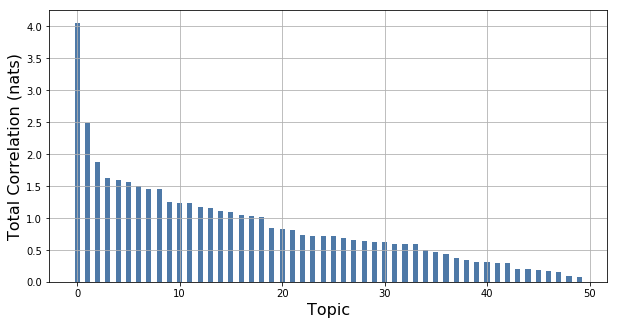

In [113]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]),
        topic_model.tcs,
        color='#4e79a7',
        width=0.5)
plt.grid()
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

как видно с графика, 1й топик наиболее информативнее

### Pointwise Document TC

В дальнейшем можна разложить total correlation - это среднее значение точечных [pointwise] общих корреляций для каждого отдельного документа

In [114]:
topic_model.log_z.shape # n_docs x k_topics

(699484, 50)

In [115]:
print(np.mean(topic_model.log_z, axis=0))
print('\n',topic_model.tcs)

[4.05000029 2.48911312 1.86711668 1.62764243 1.59117997 1.55823625
 1.50272752 1.45131824 1.4498854  1.25289345 1.23741773 1.22610498
 1.16827546 1.16081589 1.10246822 1.08618679 1.03754827 1.02612825
 1.0070829  0.84166759 0.83298592 0.81792756 0.73477059 0.71898508
 0.71475703 0.71295492 0.68221007 0.65112166 0.63088773 0.62434817
 0.61659484 0.59522485 0.593867   0.58763897 0.49674223 0.46588665
 0.43347493 0.37994993 0.33445722 0.30662489 0.30444477 0.28939211
 0.28732387 0.19940515 0.19840715 0.18535422 0.17676801 0.15126567
 0.0904562  0.07938846]

 [4.05000029 2.48911312 1.86711668 1.62764243 1.59117997 1.55823625
 1.50272752 1.45131824 1.4498854  1.25289345 1.23741773 1.22610498
 1.16827546 1.16081589 1.10246822 1.08618679 1.03754827 1.02612825
 1.0070829  0.84166759 0.83298592 0.81792756 0.73477059 0.71898508
 0.71475703 0.71295492 0.68221007 0.65112166 0.63088773 0.62434817
 0.61659484 0.59522485 0.593867   0.58763897 0.49674223 0.46588665
 0.43347493 0.37994993 0.33445722 0.

`log_z` представляет собой корреляцию внутри отдельного дока объясненный конкретной темой. Использовалася для измерения, насколько "супрайзинг" документы относятся к данным темам

### Hierarchical Topic Models

атрибуты лэйблов дают двоичные выражения топика для каждого дока и топика. и этот выход мы можем использовать для входа другой модели CorEx topic model, чтобы получить латентное представление самих тем

по 1у слою можно определить к-во скрытых латентных переменных для добавления в высшие слои, изучив TCs 

In [52]:
%%time
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

CPU times: user 4min 27s, sys: 2min 55s, total: 7min 23s
Wall time: 4min 34s


In [53]:
%%time
# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

CPU times: user 9.13 s, sys: 1.04 s, total: 10.2 s
Wall time: 8.69 s


In [112]:
#from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3],
                 column_label=words,
                 max_edges=200,
                 prefix='topic-model-example')

# тут все плохо
# эту ошибку я решил, но вот дальше у них в коде какая-то лажа с параметром `prefix`

NameError: name 'unicode' is not defined

---

## визуализация

In [116]:
# посмотрим как каждый документ относится к тому или иному топику
topic_model.p_y_given_x

array([[9.99999000e-01, 1.00000000e-06, 1.00000000e-06, ...,
        2.57855363e-03, 1.45493827e-02, 4.10339739e-02],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.57635979e-03, 1.64034357e-02, 4.14124341e-02],
       [9.99999000e-01, 1.00000000e-06, 1.00000000e-06, ...,
        2.57568138e-03, 1.53463513e-02, 3.10632475e-01],
       ...,
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.57563047e-03, 1.69765277e-02, 9.90752369e-01],
       [1.00000000e-06, 1.00000000e-06, 1.00000000e-06, ...,
        2.58361228e-03, 5.14110845e-02, 3.92602527e-02],
       [1.00000000e-06, 1.00000000e-06, 2.66915401e-06, ...,
        2.58547556e-03, 1.56773840e-02, 8.19884104e-02]])

In [117]:
# возьмем для примера 1й док
topic_model.p_y_given_x[0]

array([9.99999000e-01, 1.00000000e-06, 1.00000000e-06, 4.92696548e-06,
       1.00000000e-06, 2.10134985e-06, 1.05957468e-04, 2.57977506e-05,
       4.80001209e-05, 2.53309476e-04, 2.40770269e-03, 9.80983036e-01,
       4.54598713e-06, 3.71462242e-02, 1.54180086e-05, 2.14855383e-04,
       1.98667785e-04, 1.31042309e-05, 8.04616981e-04, 5.38918436e-04,
       2.66466543e-03, 8.63314923e-05, 7.94431427e-04, 2.70707889e-03,
       8.37637854e-05, 4.58268865e-01, 2.06924673e-02, 3.25241890e-04,
       9.88442118e-04, 4.59933590e-04, 9.28765697e-01, 7.00992295e-04,
       1.13289983e-02, 3.26881840e-02, 9.80470354e-01, 9.90843988e-01,
       9.99906271e-01, 4.14787937e-02, 5.84548122e-04, 6.58429784e-03,
       2.69237708e-02, 2.84564448e-02, 8.52271018e-01, 2.11457256e-01,
       4.51314089e-02, 6.24972820e-01, 3.42359987e-02, 2.57855363e-03,
       1.45493827e-02, 4.10339739e-02])

In [118]:
# тут уже без P(), а через так званое двоичное определение
topic_model.labels

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [119]:
# создаем новый датафрейм для последующих манипуляций
theta=pd.DataFrame(topic_model.p_y_given_x)

# переименуем колонки для лучшего понимания 
old_names=list(range(NUM_TOPICS))
new_names=['topic_{}'.format(i) for i in range(NUM_TOPICS)]
theta.rename(columns=dict(zip(old_names, new_names)),inplace=True)

# добавим `docID` чтобы красиво смерджить с основным датасетом
theta['docID']=[i for i in range(df.shape[0])]

print(theta.shape)
theta.head()

(699484, 51)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,docID
0,0.999999,0.000001,0.000001,0.000005,0.000001,0.000002,0.000106,0.000026,0.000048,0.000253,...,0.028456,0.852271,0.211457,0.045131,0.624973,0.034236,0.002579,0.014549,0.041034,0
1,0.000001,0.000001,0.000001,0.002029,0.000001,0.000061,0.000002,0.999999,0.000014,0.000051,...,0.010022,0.035419,0.839145,0.155727,0.044453,0.019921,0.002576,0.016403,0.041412,1
2,0.999999,0.000001,0.000001,0.000001,0.000001,0.000002,0.000012,0.000026,0.000014,0.000012,...,0.115791,0.637377,0.038191,0.011190,0.406510,0.956483,0.002576,0.015346,0.310632,2
3,0.999999,0.000001,0.000001,0.000001,0.000001,0.000002,0.000001,0.000026,0.000048,0.000051,...,0.007410,0.003167,0.049502,0.011193,0.097020,0.007170,0.002570,0.014575,0.040930,3
4,0.000001,0.999999,0.999999,0.000014,0.000009,0.000002,0.000004,0.000026,0.000014,0.000012,...,0.025470,0.686617,0.019345,0.011193,0.044458,0.155266,0.002580,0.014834,0.999999,4


In [120]:
# собственно, мерджим по `dicID`
df_join=df[['docID','year','month','date']].merge(theta, on='docID')
print(df_join.shape)
df_join.head()

(699484, 54)


,docID,year,month,date,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,0,2018,7,2018-07-11,0.999999,0.000001,0.000001,0.000005,0.000001,0.000002,...,0.026924,0.028456,0.852271,0.211457,0.045131,0.624973,0.034236,0.002579,0.014549,0.041034
1,1,2018,7,2018-07-11,0.000001,0.000001,0.000001,0.002029,0.000001,0.000061,...,0.068684,0.010022,0.035419,0.839145,0.155727,0.044453,0.019921,0.002576,0.016403,0.041412
2,2,2018,7,2018-07-11,0.999999,0.000001,0.000001,0.000001,0.000001,0.000002,...,0.003210,0.115791,0.637377,0.038191,0.011190,0.406510,0.956483,0.002576,0.015346,0.310632
3,3,2018,7,2018-07-11,0.999999,0.000001,0.000001,0.000001,0.000001,0.000002,...,0.029408,0.007410,0.003167,0.049502,0.011193,0.097020,0.007170,0.002570,0.014575,0.040930
4,4,2018,7,2018-07-11,0.000001,0.999999,0.999999,0.000014,0.000009,0.000002,...,0.001873,0.025470,0.686617,0.019345,0.011193,0.044458,0.155266,0.002580,0.014834,0.999999


In [121]:
# групируем по годам и месяцам, суммируя P()
gb = df_join.groupby(['year', 'month'])[new_names].sum()
print(gb.shape)
gb.head(10)

(228, 50)


topic_0    topic_1     topic_2     topic_3    topic_4  \
year month                                                            
1999 8       0.000017   1.785671    0.000743    6.313389   1.318865   
     9      15.963680  29.896324   44.226029  209.609378  45.404466   
     10     11.753802  23.502189   65.046677  131.332231  40.954462   
     11      7.716009  15.247730   86.427642  152.205225  46.362591   
     12     12.122368  27.685912  103.381747  201.552420  37.156870   
2000 1      10.739747  23.946982   61.174917  147.164734  36.375583   
     2      48.875681  36.512677   76.980421  202.537523  26.340802   
     3      94.189114  38.546991   93.199631  263.191707  33.199618   
     4      86.030265  30.027165   82.340287  259.786689  47.133777   
     5      72.001525  29.174174   75.559246  306.606193  35.681976   

              topic_5     topic_6    topic_7     topic_8     topic_9  \
year month                                                             
1999 8       3.180413    1.187233   0.244435    3.956379    2.714560   
     9      57.240158   53.045613  66.461574  124.223134   64.449561   
     10     51.555751   96.700797  70.669025  114.411413   87.648342   
     11     70.700725  102.484933  83.649654  136.450604  149.278969   
     12     71.020335   78.860703  67.421542  156.116816  143.169943   
2000 1      43.101534   58.482174  44.909907   96.180668   80.279052   
     2      87.935643   76.365806  92.105291  179.061126  117.213665   
     3      71.389261   96.059554  80.962865  204.026068  114.762421   
     4      86.402268   89.636113  68.821598  248.263071  118.783722   
     5      72.172205   75.895911  68.856082  241.350280  108.053838   

               ...        topic_40    topic_41    topic_42    topic_43  \
year month     ...                                                       
1999 8         ...        3.637755    8.707718    4.299976    7.280093   
     9         ...      137.072673  227.442131  163.356348  181.424657   
     10        ...      145.857737  264.193963  203.597297  232.134306   
     11        ...      200.501585  345.926841  260.539588  283.092323   
     12        ...      159.281738  365.153773  230.381538  286.513063   
2000 1         ...      122.818034  240.290639  167.783452  189.988217   
     2         ...      167.504742  303.441643  221.474840  260.559467   
     3         ...      181.770764  310.423874  235.807591  301.896725   
     4         ...      153.775248  275.053956  200.567180  259.246770   
     5         ...      133.716128  260.171947  171.710036  252.418726   

              topic_44    topic_45    topic_46   topic_47    topic_48  \
year month                                                              
1999 8        6.379984   10.390122    4.436177   1.301719    3.473458   
     9      185.622770  222.624015  111.973678  27.197095   78.144858   
     10     209.791488  297.660412  193.087086  43.905211   86.451270   
     11     258.317115  380.819073  227.054818  51.970694  127.921277   
     12     251.665630  401.282372  230.489353  41.829195  124.962077   
2000 1      171.592209  287.388657  181.200369  38.471040   97.452941   
     2      222.808231  363.942186  236.935096  44.667691  112.679096   
     3      227.023563  425.099728  218.194170  45.222810  110.076631   
     4      234.879545  386.494933  204.005790  48.907279  110.396943   
     5      229.794862  369.444659  185.175935  35.306407  107.252537   

              topic_49  
year month              
1999 8        3.950631  
     9       98.547576  
     10     136.635307  
     11     172.326397  
     12     151.321204  
2000 1      110.992954  
     2      162.552958  
     3      189.044049  
     4      173.092250  
     5      170.339145  

[10 rows x 50 columns]

In [122]:
gb.tail(8)

topic_0     topic_1     topic_2     topic_3     topic_4  \
year month                                                               
2017 12     447.794411  440.215459  451.279510  549.843111  305.942771   
2018 1      423.776583  409.121729  382.800653  510.142697  300.038696   
     2      483.696738  362.446114  441.189529  530.072347  326.136789   
     3      423.971248  355.225727  369.738458  664.368240  351.937300   
     4      399.550024  371.695148  431.289251  566.281436  369.262962   
     5      436.620980  396.075396  387.076836  597.111326  305.671876   
     6      609.787981  374.785864  342.091964  503.969924  300.830833   
     7      470.575617  228.591238  247.171112  404.405718  238.197865   

               topic_5     topic_6     topic_7     topic_8     topic_9  \
year month                                                               
2017 12     244.805820  327.659305  306.815613  512.956485  378.134873   
2018 1      295.961573  268.924110  305.565411  348.574905  276.300170   
     2      372.724626  271.288221  331.869831  454.191043  412.152595   
     3      292.064811  264.479170  220.938217  532.601716  378.578167   
     4      323.562722  284.016125  341.214834  410.046761  381.701211   
     5      325.635994  311.346764  326.709228  434.919419  366.632145   
     6      280.336797  281.136201  431.249005  390.066846  333.540076   
     7      215.893644  233.270354  188.704926  294.934627  254.663991   

               ...        topic_40     topic_41     topic_42    topic_43  \
year month     ...                                                         
2017 12        ...      455.660892   896.798718   959.217574  738.003498   
2018 1         ...      427.689240   908.857273   854.118936  634.377261   
     2         ...      455.541297   987.860212  1012.746765  690.343877   
     3         ...      577.173815  1027.905006   961.691677  806.784089   
     4         ...      586.318930  1079.300190   974.791717  874.852432   
     5         ...      609.895195  1021.461753  1000.784362  807.782620   
     6         ...      618.997641   997.542226   982.065656  716.891357   
     7         ...      437.273519   736.318663   704.355173  563.120081   

              topic_44     topic_45     topic_46    topic_47    topic_48  \
year month                                                                 
2017 12     577.168996  1148.263585  1068.552186  171.052586  336.776769   
2018 1      541.035413   953.796295  1093.383355  150.870891  325.196904   
     2      638.547528  1042.882136  1048.188352  164.254970  345.385349   
     3      741.556605  1162.235085   845.604635  169.708788  380.234732   
     4      740.621139  1154.003484   806.106567  271.677092  376.730672   
     5      749.512619  1173.785186   898.592187  228.679019  366.596885   
     6      632.903034  1107.278677   857.874767  200.119899  338.474051   
     7      491.336585   775.017815   616.285447  133.079744  254.650633   

              topic_49  
year month              
2017 12     612.349362  
2018 1      476.225822  
     2      535.501292  
     3      529.728957  
     4      463.076918  
     5      500.455356  
     6      492.141470  
     7      398.563549  

[8 rows x 50 columns]

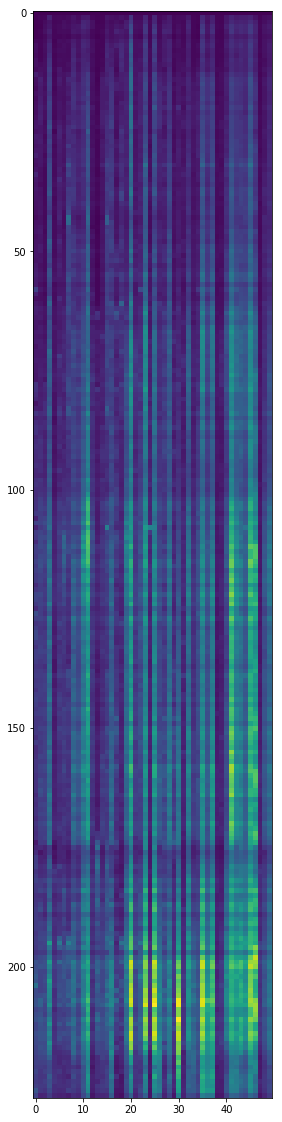

In [123]:
# отрисовываем Straightforward matrix heatmap
plt.figure(figsize=(10, 20))
plt.imshow(gb[new_names])

### рисуем через `Pygal` & `Plotly`

In [125]:
# для дальнейших графиков, готовим датасет - в каждой строке: год, месяц, P() топиков
gb_reset_index=gb.reset_index()
print(gb_reset_index.shape)
gb_reset_index.head()

(228, 52)


,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,1999,8,0.000017,1.785671,0.000743,6.313389,1.318865,3.180413,1.187233,0.244435,...,3.637755,8.707718,4.299976,7.280093,6.379984,10.390122,4.436177,1.301719,3.473458,3.950631
1,1999,9,15.963680,29.896324,44.226029,209.609378,45.404466,57.240158,53.045613,66.461574,...,137.072673,227.442131,163.356348,181.424657,185.622770,222.624015,111.973678,27.197095,78.144858,98.547576
2,1999,10,11.753802,23.502189,65.046677,131.332231,40.954462,51.555751,96.700797,70.669025,...,145.857737,264.193963,203.597297,232.134306,209.791488,297.660412,193.087086,43.905211,86.451270,136.635307
3,1999,11,7.716009,15.247730,86.427642,152.205225,46.362591,70.700725,102.484933,83.649654,...,200.501585,345.926841,260.539588,283.092323,258.317115,380.819073,227.054818,51.970694,127.921277,172.326397
4,1999,12,12.122368,27.685912,103.381747,201.552420,37.156870,71.020335,78.860703,67.421542,...,159.281738,365.153773,230.381538,286.513063,251.665630,401.282372,230.489353,41.829195,124.962077,151.321204


In [126]:
# добавляем дату
gb_reset_index['date']=gb_reset_index.apply(lambda x: prepare_date2vis(x.year,x.month),axis=1)
gb_reset_index.head(2)

,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49,date
0,1999,8,0.000017,1.785671,0.000743,6.313389,1.318865,3.180413,1.187233,0.244435,...,8.707718,4.299976,7.280093,6.379984,10.390122,4.436177,1.301719,3.473458,3.950631,1999-08-11
1,1999,9,15.963680,29.896324,44.226029,209.609378,45.404466,57.240158,53.045613,66.461574,...,227.442131,163.356348,181.424657,185.622770,222.624015,111.973678,27.197095,78.144858,98.547576,1999-09-11


In [133]:
gb_reset_index.to_csv('data/corex-50-200-probability.csv',index=False)

In [127]:
# файл `visualizer.py` взял с https://github.com/ods-ai-ml4sg/proj_news_viz/tree/basic_visualiser/visualization
import visualizer as tmp_vis
#pip install pygal, plotly

* ### TopicVisualizerPygal

In [128]:
%%time
pgv_pygal=tmp_vis.TopicVisualizerPygal(data=gb_reset_index.iloc[:,2:],topics=new_names)

CPU times: user 1.84 ms, sys: 27 ms, total: 28.9 ms
Wall time: 70.5 ms


In [129]:
%%time
pgv_pygal.draw()

file:///var/folders/jt/8trbfx7122q92zx4447hlz0w0000gp/T/tmp8fz7_m1d.html
CPU times: user 239 ms, sys: 116 ms, total: 355 ms
Wall time: 780 ms


In [130]:
%%time
pgv_pygal.save('./pygal-corex_50-200.svg')
# чтобы просмотреть, откройте этот файл у себя в браузере

CPU times: user 228 ms, sys: 11.2 ms, total: 239 ms
Wall time: 248 ms


* ### TopicVisualizerPlotly

In [131]:
%%time
pgv_plotly=tmp_vis.TopicVisualizerPlotly(data=gb_reset_index.iloc[:,2:],topics=new_names,
                                        username='your_username', api_key='your-api_key')

CPU times: user 2.72 ms, sys: 8.34 ms, total: 11.1 ms
Wall time: 17.7 ms


In [132]:
%%time
pgv_plotly.draw()
# можете перейти по урле ниже, чтобы посмотреть результат

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~vtrokhymenko/0 or inside your plot.ly account where it is named 'Topics over time'
CPU times: user 298 ms, sys: 154 ms, total: 452 ms
Wall time: 3.35 s


---

# Выводы:

* довольно простая имплементация tm
* можно добавлять руками свои токены для каждого топика
* есть возможность сделать иерархическую tm, но есть пробелы у них в коде
* можно сказать что долго считает (но ночь все решает)